# Building Predictive Models

In [2]:
import pandas as pd
import os 
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
# performance metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, precision_recall_curve

# Dummy Classifier
from sklearn.dummy import DummyClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# XGBoost
from xgboost import XGBClassifier

# multilayer perceptron
from sklearn.neural_network import MLPClassifier

# model explanation
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt

# for warning ignore
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [3]:
# set the path of the processed data
processed_data_path = os.path.join(os.path.pardir, 'data', 'processed')
train_file_path = os.path.join(processed_data_path, 'train.csv')
test_file_path = os.path.join(processed_data_path, 'test2.csv')

In [4]:
X_train = pd.read_csv(train_file_path)
y_train = pd.read_csv(test_file_path)

#X = X_train.loc[:,:].as_matrix().astype('float')
#y = y_train['subscription'].ravel()

In [5]:
X = X_train
y = y_train

In [6]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=0)

## Baseline Model

In [7]:
# create model 
model_dummy = DummyClassifier(strategy='most_frequent', random_state=0)
# train model
model_dummy.fit(X_train, y_train)

DummyClassifier(random_state=0, strategy='most_frequent')

In [8]:
y_pred_dummy = model_dummy.predict(X_test)
print("Accuracy of baseline model classifier on test set: {:.2f}".format(model_dummy.score(X_test, y_test)))

Accuracy of baseline model classifier on test set: 0.48


# ROC Curve

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance

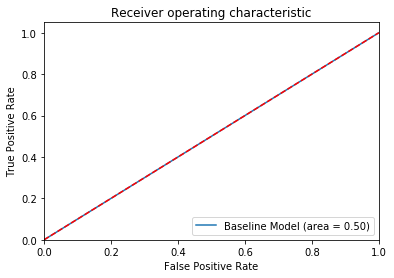

In [9]:
logit_roc_auc = roc_auc_score(y_test, model_dummy.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_dummy.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Baseline Model (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [10]:
figure_path = os.path.join(os.path.pardir, 'reports','figures')

In [11]:
def model_classifier(model, X, y, cv):
    """
    Creates folds manually, perform 
    Returns an array of validation (recall) scores
    """
    scores = []
    
    
    for train_index,test_index in cv.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        # Fit the model on the training data
        model_obj = model.fit(X_train, y_train)
        y_pred = model_obj.predict(X_test)
        y_pred_prob = model_obj.predict_proba(X_test)[:,1]
        # Score the model on the validation data
        score = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        scores.append(score)
        mean_score = np.array(scores).mean()    

    print('Accuracy scores of the model: {:.2f}'.format(mean_score))
    print('\n Classification report of the model')
    print('--------------------------------------')
    print(report)
    
    print('\n Confusion Matrix of the model')
    print('--------------------------------------')
    print(conf_matrix)
    
    print("\n ROC Curve")
    
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure()
    val_model = input("Enter your model name: ")
    plt.plot(fpr, tpr, label= val_model + ' (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    my_fig = val_model + '.png'
    plt.savefig(os.path.join(figure_path, my_fig))
    plt.show()

# Logistic Regression

In [12]:
lr = LogisticRegression()
kf = KFold(n_splits = 10, shuffle = True, random_state = 4)
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4)

## KFold

Accuracy scores of the model: 0.73

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      3636
           1       0.75      0.68      0.71      3673

    accuracy                           0.73      7309
   macro avg       0.73      0.73      0.73      7309
weighted avg       0.73      0.73      0.73      7309


 Confusion Matrix of the model
--------------------------------------
[[2823  813]
 [1191 2482]]

 ROC Curve


Enter your model name:  Logistic-Regression-kf


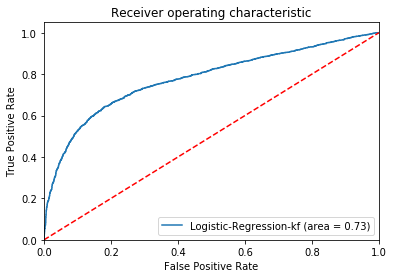

In [13]:
model_classifier(lr, X, y, kf)

## Stratified KFold

Accuracy scores of the model: 0.73

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3654
           1       0.76      0.68      0.72      3655

    accuracy                           0.73      7309
   macro avg       0.74      0.73      0.73      7309
weighted avg       0.74      0.73      0.73      7309


 Confusion Matrix of the model
--------------------------------------
[[2874  780]
 [1170 2485]]

 ROC Curve


Enter your model name:  Logistic-Regression-skf


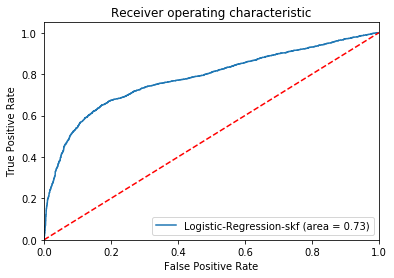

In [14]:
model_classifier(lr, X, y, skf)

## Logistic Regression Hyperparameter Tuning

Accuracy scores of the model: 0.73

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      3636
           1       0.75      0.68      0.71      3673

    accuracy                           0.73      7309
   macro avg       0.73      0.73      0.73      7309
weighted avg       0.73      0.73      0.73      7309


 Confusion Matrix of the model
--------------------------------------
[[2823  813]
 [1191 2482]]

 ROC Curve


Enter your model name:  Tune-Logistic-Regression-tf


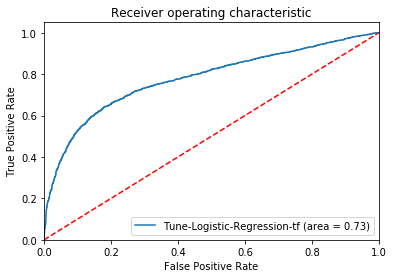

In [15]:
lr_hyp = LogisticRegression()

# regularization penalty space
penalty = ['l1','l2']
solver = ['liblinear', 'saga']

# regularization hyperparameter space
#C = np.logspace(0, 4, 10)
C = np.logspace(0, 4, num=10)

# hyperparameter options
param_grid = dict(C=C, penalty=penalty, solver=solver)

log_reg_cv = RandomizedSearchCV(lr_hyp, param_grid)

model_classifier(log_reg_cv, X, y, kf)

### Stratified KFold

Accuracy scores of the model: 0.73

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3654
           1       0.76      0.68      0.72      3655

    accuracy                           0.73      7309
   macro avg       0.74      0.73      0.73      7309
weighted avg       0.74      0.73      0.73      7309


 Confusion Matrix of the model
--------------------------------------
[[2874  780]
 [1170 2485]]

 ROC Curve


Enter your model name:  Tuned-Logistic-Regression-skf


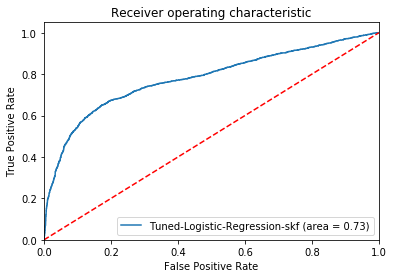

In [16]:
model_classifier(log_reg_cv, X, y, skf)

# XGBoost

In [17]:
xgb = XGBClassifier()

### XGBoost KFold

Accuracy scores of the model: 0.84

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      3636
           1       0.87      0.83      0.85      3673

    accuracy                           0.85      7309
   macro avg       0.85      0.85      0.85      7309
weighted avg       0.85      0.85      0.85      7309


 Confusion Matrix of the model
--------------------------------------
[[3164  472]
 [ 618 3055]]

 ROC Curve


Enter your model name:  XGBoost-fk


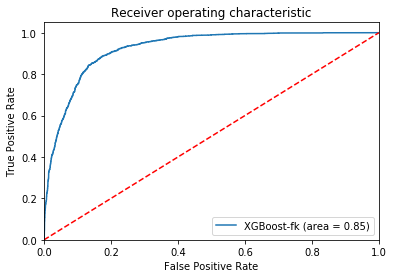

In [18]:
model_classifier(xgb, X, y, kf)

### XGBoost : Stratified KFold

Accuracy scores of the model: 0.85

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3654
           1       0.87      0.83      0.85      3655

    accuracy                           0.85      7309
   macro avg       0.85      0.85      0.85      7309
weighted avg       0.85      0.85      0.85      7309


 Confusion Matrix of the model
--------------------------------------
[[3199  455]
 [ 624 3031]]

 ROC Curve


Enter your model name:  XGBoost-sfk


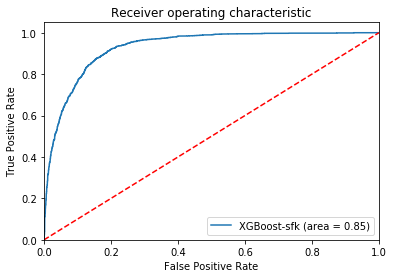

In [19]:
model_classifier(xgb, X, y, skf)

### Hyperparameter tuning XGBoost 

In [20]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [21]:
# A parameter grid for XGBoost
from datetime import datetime
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb_hyp = XGBClassifier()

xgb_random_search = RandomizedSearchCV(xgb_hyp, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=10, verbose=3)


start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_random_search.fit(X, y)
timer(start_time)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.9min finished



 Time taken: 0 hours 17 minutes and 13.59 seconds.


In [22]:
xgb_random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
xgb_random_search.best_params_

{'subsample': 1.0,
 'min_child_weight': 1,
 'max_depth': 4,
 'gamma': 0.5,
 'colsample_bytree': 1.0}

Accuracy scores of the model: 0.78

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      3654
           1       0.84      0.71      0.77      3655

    accuracy                           0.79      7309
   macro avg       0.79      0.79      0.78      7309
weighted avg       0.79      0.79      0.78      7309


 Confusion Matrix of the model
--------------------------------------
[[3154  500]
 [1071 2584]]

 ROC Curve


Enter your model name:  Tuned-XGBoost-skf


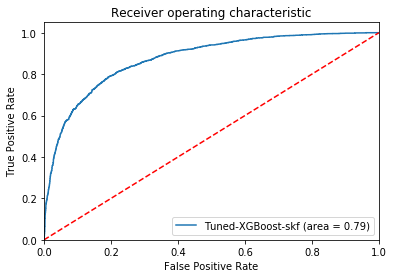

In [25]:
xgb_tuned = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)
model_classifier(xgb_tuned,X,y,skf)

## MLP Classifier

In [26]:
mlp = MLPClassifier()

### KFold

Accuracy scores of the model: 0.75

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      3636
           1       0.81      0.67      0.73      3673

    accuracy                           0.76      7309
   macro avg       0.76      0.76      0.75      7309
weighted avg       0.76      0.76      0.75      7309


 Confusion Matrix of the model
--------------------------------------
[[3076  560]
 [1223 2450]]

 ROC Curve


Enter your model name:  Multilayer-Perceptron-skf


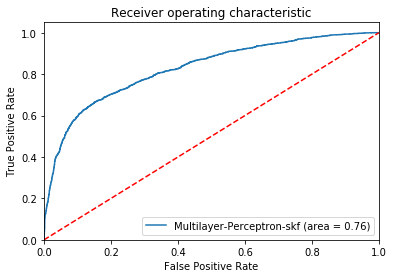

In [29]:
model_classifier(mlp, X, y, kf)

### Stratified KFold

Accuracy scores of the model: 0.75

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      3654
           1       0.80      0.68      0.74      3655

    accuracy                           0.76      7309
   macro avg       0.76      0.76      0.75      7309
weighted avg       0.76      0.76      0.75      7309


 Confusion Matrix of the model
--------------------------------------
[[3049  605]
 [1176 2479]]

 ROC Curve


Enter your model name:  Multilayer-Perceptron-skf


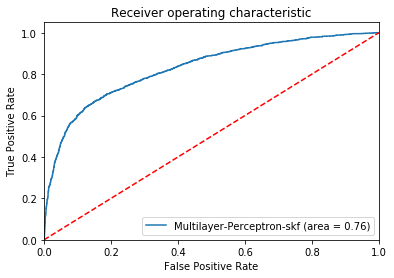

In [28]:
model_classifier(mlp, X, y, skf)

## Hyperparameter Tuning : MLP

In [30]:
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp_hyp = MLPClassifier()
randomized_mlp = RandomizedSearchCV(mlp_hyp, parameter_space, n_jobs=-1, cv=10)
start_time = timer(None) # timing starts from this point for "start_time" variable
randomized_mlp.fit(X, y)
timer(start_time)


 Time taken: 1 hours 43 minutes and 30.84 seconds.


In [31]:
randomized_mlp.best_estimator_

MLPClassifier(hidden_layer_sizes=(20,), learning_rate='adaptive', solver='sgd')

In [32]:
randomized_mlp.best_params_

{'solver': 'sgd',
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (20,),
 'alpha': 0.0001,
 'activation': 'relu'}

In [ ]:
tuned_mlp = MLPClassifier(hidden_layer_sizes=(20,), learning_rate='adaptive', solver='sgd')

model_classifier(tuned_mlp, X, y, skf)

Accuracy scores of the model: 0.73

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      3654
           1       0.79      0.66      0.72      3655

    accuracy                           0.74      7309
   macro avg       0.75      0.74      0.74      7309
weighted avg       0.75      0.74      0.74      7309


 Confusion Matrix of the model
--------------------------------------
[[3014  640]
 [1253 2402]]

 ROC Curve
